# Rainy days on the stock market

Dataproject by Josefine Pedersen, Viktor Texel and Pernille Svendsen

> **Table of contents** 
> - Import and set magics
> - Introduction
- Indsæt billede og forklar data
> - Read and clean data from DMI and Yahoo Finance
> - Explore each dataset
- 2 plots med hhv. nedbør og OMXC25 fordelt på måneder --> 1 plot med 2 firkanter heri hvor hvert plot kan ses. Herudover også et interaktivt plot hvor man kan udvælge på specifikke måneder for begge plots samtidig.  
> - Merge datasets
> - Analysis
- Vi skal flytte change_stock til analysis og vise de 10 dage med mest nedgang/fremgang på stockmarkedet og sammenholde med nedbør på disse dage. 
> - Conclusion

- Overvej mulighed for at streamline data ved at lægge ind i py-filen. 

*Imports and set magics:*

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import requests # library for making HTTP requests
import datetime as dt # library for handling date and time objects


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

In this dataproject we wish to explore if there could be a correlation between weather and developments on the stock market. Through API's we import datasets from DMI and Yahoo Finance to examine whether or not there is a correlation between price fluktuations in the danish OMX C25-index and the amount of precipitation that falls in Denmark. 

# Read and clean data from DMI and Yahoo Finance

Import your data, either through an API or manually, and load it. 

**We import data from DMI**:

In [7]:
# We install a package to inspect data from DMI (Danish Meteorological Institute):

#%pip install dmi-open-data

In [8]:
# We use our API-key given to us from DMI's database
api_key = 'bd463c7d-f6f8-431d-a5a7-c466766a8363'

DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
r = requests.get(DMI_URL, params={'api-key': api_key}) # Issues a HTTP GET request
print(r)

<Response [200]>


In [9]:
json = r.json()  # Extract JSON data
print(json.keys())  # Print the keys of the JSON dictionary

df = pd.json_normalize(json['features'])  # Convert JSON object to a Pandas DataFrame


dict_keys(['type', 'features', 'timeStamp', 'numberReturned', 'links'])


In [10]:
df['time'] = pd.to_datetime(df['properties.observed'])


In [11]:
parameter_ids = df['properties.parameterId'].unique()  # Generate a list of unique parameter ids
print(parameter_ids)  # Print all unique parameter ids

['temp_dew' 'humidity' 'cloud_cover' 'temp_max_past12h' 'pressure_at_sea'
 'wind_speed' 'temp_soil_max_past1h' 'weather' 'wind_dir' 'temp_dry'
 'precip_dur_past10min' 'temp_grass' 'leav_hum_dur_past10min'
 'temp_min_past1h' 'precip_past1min' 'precip_past1h' 'pressure'
 'radia_glob' 'wind_speed_past1h' 'humidity_past1h' 'sun_last10min_glob'
 'precip_past10min' 'visib_mean_last10min' 'leav_hum_dur_past1h'
 'visibility' 'temp_soil' 'temp_soil_min_past1h' 'wind_min'
 'temp_grass_min_past1h' 'wind_min_past1h' 'cloud_height'
 'temp_min_past12h' 'wind_max_per10min_past1h' 'temp_max_past1h'
 'temp_soil_mean_past1h' 'wind_max' 'wind_dir_past1h' 'precip_dur_past1h'
 'temp_grass_mean_past1h' 'wind_gust_always_past1h' 'sun_last1h_glob'
 'temp_mean_past1h' 'radia_glob_past1h' 'temp_grass_max_past1h'
 'snow_depth_man']


In [12]:
# Specify the desired start and end time
start_time = pd.Timestamp(2022, 1, 1)
end_time = pd.Timestamp(2023, 1, 1)

# Specify one or more station IDs or all_stations
all_stationsDK = [
    '05005', '05009', '05015', '05031', '05035', '05042', '05065', 
    '05070', '05075', '05081', '05085', '05089', '05095', '05105', 
    '05109', '05135', '05140', '05150', '05160', '05165', '05169', 
    '05185', '05199', '05202', '05205', '05220', '05225', '05269', 
    '05272', '05276', '05277', '05290', '05296', '05300', '05305', 
    '05320', '05329', '05343', '05345', '05350', '05355', '05365', 
    '05375', '05381', '05395', '05400', '05406', '05408', '05435', 
    '05440', '05450', '05455', '05469', '05499', '05505', '05510', 
    '05529', '05537', '05545', '05575', '05735', '05880', '05889', 
    '05935', '05945', '05970', '05986', '05994'
]

# Specify one or more parameter IDs or all_parameters
parameterId = ['precip_past1h']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

dfs = []
for station in all_stationsDK:
    for parameter in parameterId:
        # Specify query parameters
        params = {
            'api-key' : api_key,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '300000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL, params=params)
        # Extract JSON object
        json = r.json() # Extract JSON object
        # Convert JSON object to a MultiIndex DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        if dfi.empty is False:
            dfi['Time'] = pd.to_datetime(dfi['properties.observed'])
            dfi[['station', 'parameter']] = station, parameter
            #dfi = dfi.set_index(['parameter', 'station', 'Time'])
            #dfi = dfi['properties.value'].unstack(['station','parameter'])
            dfi = dfi.set_index(['station', 'Time'])
            dfi = dfi['properties.value'].unstack(['station'])
            dfs.append(dfi)

df = pd.concat(dfs, axis='columns').sort_index()
df.head()



station,05005,05009,05015,05031,05035,05042,05065,05070,05075,05081,...,05545,05575,05735,05880,05889,05935,05945,05970,05986,05994
Time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.08,0.0
2022-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0


In [13]:
df.reset_index(inplace=True) 
list(df.columns)
df


station,Time,05005,05009,05015,05031,05035,05042,05065,05070,05075,...,05545,05575,05735,05880,05889,05935,05945,05970,05986,05994
0,2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.00,NaN,0.00,0.00,0.00,NaN,NaN,0.00,0.00,0.00
1,2022-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.00,NaN,0.00,0.00,0.00,NaN,NaN,0.00,0.08,0.00
2,2022-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,NaN,NaN,0.00,0.00,0.00,NaN,NaN,0.00,0.00,0.00
3,2022-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,NaN,NaN,0.00,0.00,0.00,NaN,NaN,0.00,0.00,0.00
4,2022-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,NaN,NaN,0.00,0.00,0.00,NaN,NaN,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8734,2022-12-31 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,NaN,0.00,0.00,...,0.13,0.08,0.22,0.17,0.77,0.43,0.56,0.61,0.93,0.00
8735,2022-12-31 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,NaN,0.00,0.00,...,0.78,0.29,1.02,0.35,1.36,1.20,0.74,0.88,0.75,1.40
8736,2022-12-31 22:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,NaN,0.00,0.00,...,0.51,0.41,0.40,1.19,1.81,1.59,1.03,3.20,1.18,0.53
8737,2022-12-31 23:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.31,NaN,0.13,0.18,...,1.17,1.48,1.05,1.26,2.19,3.82,2.75,3.05,1.38,0.21


In [14]:
# We create a row-average of the observations across weather stations
df['Precip'] = df.mean(axis=1)
df['Date'] = df.Time.dt.date 
df2 = df[['Time', 'Date', 'Precip']] 
df2.drop(df2.tail(1).index,inplace=True) # drop last n rows
df2


/var/folders/12/8qxsq5yd75n7_tx6ptkgmplw0000gn/T/ipykernel_74381/3220302073.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df['Precip'] = df.mean(axis=1)
/var/folders/12/8qxsq5yd75n7_tx6ptkgmplw0000gn/T/ipykernel_74381/3220302073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(df2.tail(1).index,inplace=True) # drop last n rows


station,Time,Date,Precip
0,2022-01-01 00:00:00+00:00,2022-01-01,0.008364
1,2022-01-01 01:00:00+00:00,2022-01-01,0.034727
2,2022-01-01 02:00:00+00:00,2022-01-01,0.041296
3,2022-01-01 03:00:00+00:00,2022-01-01,0.015185
4,2022-01-01 04:00:00+00:00,2022-01-01,0.029630
...,...,...,...
8733,2022-12-31 19:00:00+00:00,2022-12-31,0.120656
8734,2022-12-31 20:00:00+00:00,2022-12-31,0.420820
8735,2022-12-31 21:00:00+00:00,2022-12-31,0.611967
8736,2022-12-31 22:00:00+00:00,2022-12-31,0.993770


In [15]:
# We check to see which days have missing hours
tjek = df2.groupby(['Date'])['Time'].count()
tjek = pd.DataFrame(tjek)
tjek

tjek2 = tjek.loc[tjek['Time']!=24]
tjek2

,Time
Date,
2022-06-14,23
2022-06-15,21
2022-06-16,22
2022-06-17,22
2022-06-18,22
2022-06-19,19
2022-06-20,22
2022-06-21,21
2022-06-22,22


In [16]:
df3 = df2.groupby('Date').mean()
df3.reset_index(inplace=True) 
df3['Date'] =pd.to_datetime(df3['Date'])
df3

/var/folders/12/8qxsq5yd75n7_tx6ptkgmplw0000gn/T/ipykernel_74381/2977789795.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df2.groupby('Date').mean()


station,Date,Precip
0,2022-01-01,0.170616
1,2022-01-02,0.186448
2,2022-01-03,0.158633
3,2022-01-04,0.106235
4,2022-01-05,0.121349
...,...,...
360,2022-12-27,0.099927
361,2022-12-28,0.568777
362,2022-12-29,0.214848
363,2022-12-30,0.117192


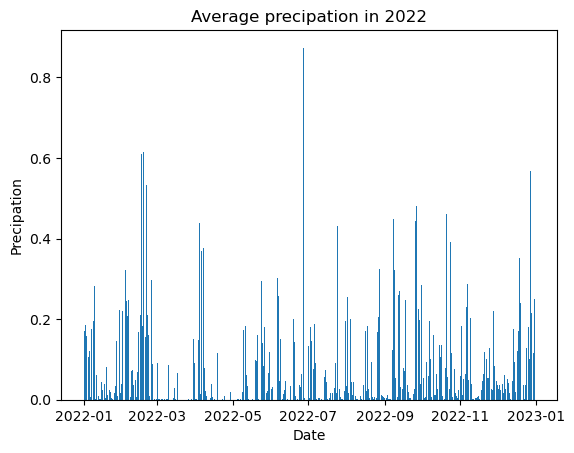

In [17]:
# a. create the figure
fig = plt.figure()

# b. plot
ax = fig.add_subplot(1,1,1)

ax.bar(df3['Date'],df3['Precip'])

ax.set_title('Average precipation in 2022')
ax.set_xlabel('Date')
ax.set_ylabel('Precipation');

**We import data from Yahoo Finance**

In [18]:
# We install nescesarry packages for import

#%pip install yfinance
#%pip install yahoofinancials

In [19]:
import yfinance as yf

from yahoofinancials import YahooFinancials

OMXC25 = yf.download('^OMXC25', start='2022-01-01', end='2023-01-01', progress=False)
OMXC25.reset_index(inplace=True) 
OMXC25['Date'] =  pd.to_datetime(OMXC25['Date'])
OMXC25


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1971.800049,1982.729980,1962.219971,1970.949951,1970.949951,10582200
1,2022-01-04,1985.459961,1985.900024,1949.790039,1952.810059,1952.810059,17283400
2,2022-01-05,1959.189941,1963.290039,1942.790039,1947.630005,1947.630005,13458600
3,2022-01-07,1886.939941,1891.569946,1865.910034,1867.989990,1867.989990,14073400
4,2022-01-10,1892.000000,1892.630005,1825.430054,1825.510010,1825.510010,14227200
...,...,...,...,...,...,...,...
245,2022-12-23,1686.979980,1701.520020,1685.209961,1695.199951,1695.199951,7560500
246,2022-12-27,1701.160034,1709.910034,1698.150024,1701.630005,1701.630005,5433400
247,2022-12-28,1702.770020,1707.079956,1693.160034,1695.209961,1695.209961,6937600
248,2022-12-29,1691.430054,1712.839966,1688.589966,1712.839966,1712.839966,7364700


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

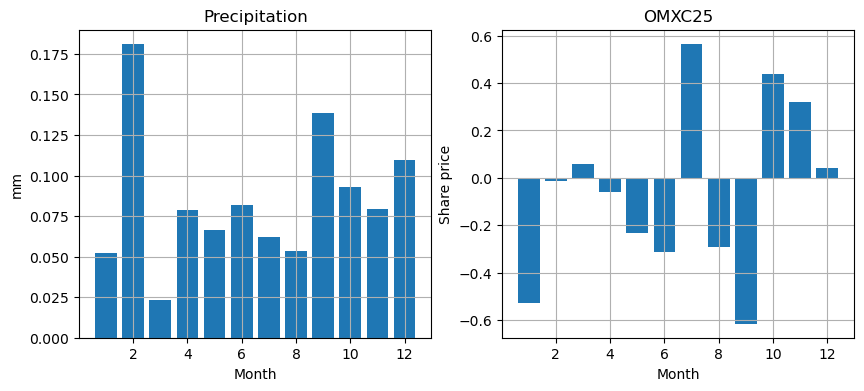

In [45]:
fig = plt.figure(figsize=(10,4))

ax_left = fig.add_subplot(1,2,1)
ax_left.set_title('Precipitation')
ax_left.grid(True)
ax_left.bar(precip_stock3['Month'],precip_stock3['Precip'])
ax_left.set_xlabel('Month')
ax_left.set_ylabel('mm')

ax_right = fig.add_subplot(1,2,2)
ax_right.set_title('OMXC25')
ax_right.grid(True)
ax_right.bar(precip_stock3['Month'],precip_stock3['Change_in_stock'])
ax_right.set_xlabel('Month')
ax_right.set_ylabel('Share price')
ax_right.locator_params(axis='both', nbins=4);

**Interactive plot** :

In [72]:
def interactive_figure(Date, Month, Change_in_stock, Precip):
    filtered_data = precip_stock3[precip_stock3['Month']==Month]

    fig = plt.figure(figsize=(10,4))

    ax_left = fig.add_subplot(1,2,1)
    ax_left.set_title('Precipitation')
    ax_left.grid(True)
    ax_left.bar(filtered_data['Date'],filtered_data['Precip'])
    ax_left.set_xlabel('Date')
    ax_left.set_ylabel('mm')

    ax_right = fig.add_subplot(1,2,2)
    ax_right.set_title('OMXC25')
    ax_right.grid(True)
    ax_right.bar(filtered_data['Date'],filtered_data['Change_in_stock'])
    ax_right.set_xlabel('Date')
    ax_right.set_ylabel('Share price')

    plt.show()

widgets.interact(interactive_figure,
    Date=widgets.fixed(precip_stock3['Date']),
    Month=widgets.Dropdown(description="Month", options=precip_stock3.Month.unique(), value=9),
    Change_in_stock=widgets.fixed(precip_stock3['Change_in_stock']),
    Precip=widgets.fixed(precip_stock3['Precip'])
);

interactive(children=(Dropdown(description='Month', index=8, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), …

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

We create combinations of our loaded data sets from DMI and Yahoo Finance.

In [22]:
precip_stock = pd.merge(OMXC25, df3, on='Date', how='left')
precip_stock2 = precip_stock[['Date', 'Close', 'Precip']]
precip_stock2


,Date,Close,Precip
0,2022-01-03,1970.949951,0.158633
1,2022-01-04,1952.810059,0.106235
2,2022-01-05,1947.630005,0.121349
3,2022-01-07,1867.989990,0.174461
4,2022-01-10,1825.510010,0.002900
...,...,...,...
245,2022-12-23,1695.199951,0.002511
246,2022-12-27,1701.630005,0.099927
247,2022-12-28,1695.209961,0.568777
248,2022-12-29,1712.839966,0.214848


In [23]:
# We calculate the pct. change from day-to-day on the closing price of OMXC25
precip_stock2['Change_in_stock'] = ((precip_stock2['Close'] / precip_stock2['Close'].shift(1) - 1)* 100)
precip_stock2

/var/folders/12/8qxsq5yd75n7_tx6ptkgmplw0000gn/T/ipykernel_74381/2100128013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precip_stock2['Change_in_stock'] = ((precip_stock2['Close'] / precip_stock2['Close'].shift(1) - 1)* 100)


,Date,Close,Precip,Change_in_stock
0,2022-01-03,1970.949951,0.158633,NaN
1,2022-01-04,1952.810059,0.106235,-0.920363
2,2022-01-05,1947.630005,0.121349,-0.265262
3,2022-01-07,1867.989990,0.174461,-4.089073
4,2022-01-10,1825.510010,0.002900,-2.274101
...,...,...,...,...
245,2022-12-23,1695.199951,0.002511,0.627434
246,2022-12-27,1701.630005,0.099927,0.379309
247,2022-12-28,1695.209961,0.568777,-0.377288
248,2022-12-29,1712.839966,0.214848,1.039989


In [77]:
# Calculate the 10 days with the most progress/decrease in the share price for the OMXC25
# Compare with the amount of rain on these days. Is there a correlation? Viktor

highest = precip_stock2.nlargest(10,'Change_in_stock') 
highest
lowest = precip_stock2.nsmallest(10, 'Change_in_stock')
lowest

,Date,Close,Precip,Change_in_stock,Month
86,2022-05-09,1579.150024,0.018073,-5.015248,5
3,2022-01-07,1867.989990,0.174461,-4.089073,1
110,2022-06-16,1514.329956,0.000181,-3.490537,6
14,2022-01-24,1719.089966,0.002116,-3.450661,1
85,2022-05-06,1662.530029,0.001922,-3.391830,5
164,2022-09-01,1598.030029,0.003558,-3.304995,9
184,2022-09-29,1419.339966,0.197864,-2.873409,9
13,2022-01-21,1780.530029,0.023261,-2.766502,1
22,2022-02-03,1768.459961,0.322891,-2.760278,2
179,2022-09-22,1483.270020,0.003168,-2.651494,9


Looking at monthly data to get a view of trends

In [47]:
precip_stock3 = precip_stock2
precip_stock3['Month'] = precip_stock3.Date.dt.month 
precip_stock4 = precip_stock3.groupby('Month').mean()
precip_stock4.reset_index(inplace=True) 
precip_stock3

/var/folders/12/8qxsq5yd75n7_tx6ptkgmplw0000gn/T/ipykernel_74381/3497838205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precip_stock3['Month'] = precip_stock3.Date.dt.month
/var/folders/12/8qxsq5yd75n7_tx6ptkgmplw0000gn/T/ipykernel_74381/3497838205.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  precip_stock4 = precip_stock3.groupby('Month').mean()


,Date,Close,Precip,Change_in_stock,Month
0,2022-01-03,1970.949951,0.158633,NaN,1
1,2022-01-04,1952.810059,0.106235,-0.920363,1
2,2022-01-05,1947.630005,0.121349,-0.265262,1
3,2022-01-07,1867.989990,0.174461,-4.089073,1
4,2022-01-10,1825.510010,0.002900,-2.274101,1
...,...,...,...,...,...
245,2022-12-23,1695.199951,0.002511,0.627434,12
246,2022-12-27,1701.630005,0.099927,0.379309,12
247,2022-12-28,1695.209961,0.568777,-0.377288,12
248,2022-12-29,1712.839966,0.214848,1.039989,12


Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.